# Block 3
We have a detector that measures hit positions in an $(x; y)$ plane in the range $([-1,1],[-1,1])$ and
the energy (E) in the range $[0,10]$, in arbitrary units.

Using such a detector, we perform an experiment with the aim of statistically establishing
the detection of events of type signal, in the presence of events of type background. Signal and
background events have different p.d.f.'s for x, y and E. The result of our experiment is provided
in the input file data `On.txt`.

In an independent experiment, using the same detector, we measure in conditions such that only
background events are collected. We measure for 3 times longer and therefore we expect 3 times
more background events in the Off data sample than in the On data sample. The results are
provided in the input file data `Off.txt`.

In order to study the best way to separate signal from background using the spatial information
we use two independent simulated samples (train and test) for signal and background events, re-
spectively. Those are train `signal.txt`, `train bkg.txt`, `test signal.txt` and `test bkg.txt`.

The joint p.d.f.'s for the spatial coordinates for signal and background events are, respectively:

$$
f_s(
$$
with $a = b = 6$ and $c = -5$, for signal, and
$$
f_b(
$$
with $r = \sqrt{x^2 + y^2}$, $r0 = 0.6$ and $\sigma_r = 0.4$, for background.

In addition, we know that the spectrum of signal and background events have, respectively, the following shapes:
$$
\frac{dN_S}{d_E}
$$
with $E_0$ known to be in the range $[0,10]$ and $\sigma_E = 1$, for signal, and
$$
\frac{dN_b}{d_E}
$$
with $\gamma > 1/5$, for background.

## 1. Select, out of the data and background-control samples, signal-enriched subsamples following these steps:
### (a) Using the train sample and/or the known spatial p.d.f.'s for signal and background events, consider/construct the following test statistics:
 * The radial distance $r = \sqrt{x^2 + y^2}$
 * A Fisher discriminant using as input the polar coordinates $(r,\theta)$, with $\theta = tan^{-1}(y/x)$. Comment why using $r$ and $\theta$ should be better than using $x$ and $y$.
 * The exact 
 * The likelihood ratio estimated from the train sample.
 * A neural network (use, e.g. scikit-learn MLPRegressor class, more information at scikit-lern.org)

In [1]:
%matplotlib inline
#%matplotlib
import numpy as np

import scipy.stats as stat
import scipy.integrate as pyint
import scipy.optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import sklearn.preprocessing as preproc
import sklearn.neural_network as nn

In [8]:
# function to creat a 3d histogram
def hist3d(x,y,bins=5,fig=None,ax=None,alpha=None):
    # Note: fig and ax are inputs in order to allow the caller to create 
    # them outside and in this way, modify labels and legents once the function has been called
    # In addition, they being inputs allows to use this function to create subplots
    # x and y are the positions in the plane of the data
    # bins is directly passed to np.histugram2d, and therefore, accepts the same options as numpy https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram2d.html
    
    # for simplicity, fig and ax arguments are optional, therefore, if they are the default value None, 
    # they are created directly inside the function
    if fig==None:
        fig = plt.figure()
    if ax==None:
        ax = fig.add_subplot(111, projection='3d')
        
    # Call np.histogramm2d, it returns a 2d array H with the number of data points inside the area 
    # delimited by xedges and yedges
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=1)
    
    # Construct arrays with the lower, left corner of the bars
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
    xpos = xpos.flatten('F') ; ypos = ypos.flatten('F') ; zpos = np.zeros_like(xpos)

    # Construct arrays with the dimensions of the bars. It assumes that spacings only depend on the axis
    dx = (xedges[1]-xedges[0]) * np.ones_like(zpos) ; dy = (yedges[1]-yedges[0]) * np.ones_like(zpos)
    dz = H.flatten()

    #Choose colors according to colormap. As our data is normalized between 0 ans 1 but all vales may be small,
    # they are rescaled for aesthetic reasons
    plot_colors = cm.jet(dz/dz.max())
    
    # Plot. bar3d arguments are the cordinates of the vertex and the dimensions in each of the 3 axis, 
    # the other arguments are optional
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=plot_colors, alpha=alpha)
    return

#####################          General (test independent)          #####################

fs_norm = pyint.dblquad(lambda x,y: np.exp(-6*(x**2+y**2)+10*x*y),-1,1,lambda x: -1,lambda x: 1)[0]
def fs_xy(y,x):
    cosa = -6*(x**2+y**2)+10*x*y
    return np.exp(cosa)/fs_norm

def fs_polar(r,theta):
    cosa = 6-5*np.sin(2*theta)
    return r*np.exp(-r**2*cosa)/fs_norm

fb_norm = pyint.dblquad(lambda x,y: np.exp(-((np.sqrt(x**2+y**2)-0.6)/0.4)**2/2),-1,1,lambda x: -1,lambda x: 1)[0]
def fb_xy(x,y): 
    return np.exp(-((np.sqrt(x**2+y**2)-0.6)/0.4)**2/2)/fb_norm

def fb_polar(r,theta):
    return np.exp(-((r-0.6)/0.4)**2/2)/fb_norm

#####################          Test Radial distance          #####################
def rTest(Tcut):
    # rTest returns alpha and beta for the radius test. It is divided in two cases, r<1 and r between 1 and sqrt(2).
    # that is because the integration regions are defined in a different way depending on that because x and y are 
    # restricted to -1,1 which is a square.
    r = Tcut
    if r<1:
        # here the region is simply a circle which fits completely insithe the -1,1 square or the complementary
        alpha =  1.-pyint.dblquad(fs_xy,-r,r,lambda x: -np.sqrt(r**2-x**2),lambda x: np.sqrt(r**2-x**2))[0]
        beta = pyint.dblquad(fb_xy,-r,r,lambda x: -np.sqrt(r**2-x**2),lambda x: np.sqrt(r**2-x**2))[0]
    else:
        # here the regions are the corners left between the circle which is bigger than the square or the complementary.
        # due to symmetry, the 4 corners can be divided in two, the corners of x=y (called plus) and the corners 
        # of x=-y (called minus)
        plus_a = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: np.sqrt(r**2-x**2),lambda x: 1)[0]
        minus_a = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: -1,lambda x: -np.sqrt(r**2-x**2))[0]
        alpha =  plus_a+minus_a
        plus_b = 2.*pyint.dblquad(fb_xy,np.sqrt(r**2-1),1,lambda x: np.sqrt(r**2-x**2),lambda x: 1)[0]
        minus_b = 2.*pyint.dblquad(fb_xy,np.sqrt(r**2-1),1,lambda x: -1,lambda x: -np.sqrt(r**2-x**2))[0]
        beta = 1-plus_b-minus_b
    return alpha,beta

#####################          Test Fisher          #####################
def findFish(SX,SY,BX,BY):
    # findFish returns a and data necessary for the posterior sections properly organized in the desired arrays.
    # By doing this, all the calculations needed to apply the fisherTest() are reduced to one line.
    SR = np.sqrt(SX**2 + SY**2) ; BR = np.sqrt(BX**2 + BY**2)
    STheta = np.arctan(SY/SX) ; BTheta = np.arctan(BY/BX)

    # fishdata is an array containing two rows, r and theta, and a column for each observation
    Sfishdata = np.array([SR,STheta]) ; Bfishdata = np.array([BR,BTheta])
    Smu = np.array([np.mean(SR),np.mean(STheta)]) ; Bmu = np.array([np.mean(BR),np.mean(BTheta)])
    
    # Cov are the covariance matrixes between r and theta
    SCov = np.cov(Sfishdata) ; BCov = np.cov(Bfishdata)
    
    #see p.15 in the PPT "Hypothesis Testing"
    W = SCov+BCov
    a = np.dot(np.linalg.inv(W),Smu-Bmu)
    return a, Sfishdata, Bfishdata, SCov, BCov

def fisherTest(sample,a):
    # fisher test return the value of T for each observation in the sample.
    # a: is an input and must correspond to the variables in sample
    # sample: is an array containing two rows, r and theta, and a column for each observatio
    T = np.dot(a,sample)
    return T

In [3]:
trnS = np.loadtxt('Block3_data/train_signal.txt',skiprows=2,usecols=(0,1))
trnB = np.loadtxt('Block3_data/train_bkg.txt',skiprows=2,usecols=(0,1))
tstS = np.loadtxt('Block3_data/test_signal.txt',skiprows=2,usecols=(0,1))
tstB = np.loadtxt('Block3_data/test_bkg.txt',skiprows=2,usecols=(0,1))

### Radial distance

When doing this exercise for the radial distance, r becomes our "T" variable

#### Train

In [4]:
# Signal
trnSX = trnS[:,0] ; trnSY = trnS[:,1]
trnSR = np.sqrt(trnSX**2 + trnSY**2)
# Background
trnBX = trnB[:,0] ; trnBY = trnB[:,1]
trnBR = np.sqrt(trnBX**2 + trnBY**2)

#### Test

In [5]:
# Signal
tstSX = tstS[:,0] ; tstSY = tstS[:,1]
tstSR = np.sqrt(tstSX**2 + tstSY**2)
# Background
tstBX = tstB[:,0] ; tstBY = tstB[:,1]
tstBR = np.sqrt(tstBX**2 + tstBY**2)

Comparison train vs test

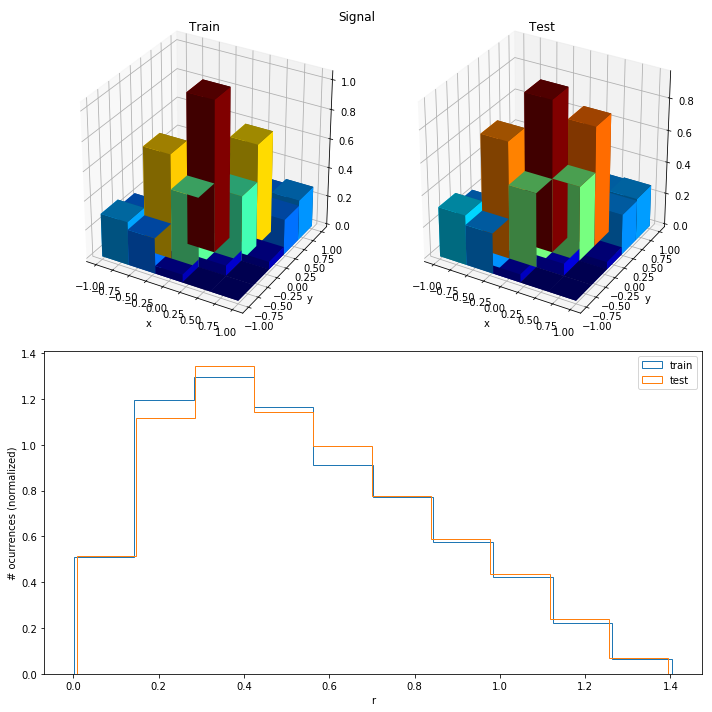

In [6]:
fig=plt.figure(figsize=(10,10))
fig.suptitle('Signal')
ax1=fig.add_subplot(221,projection='3d')
#ax1.hist2d(trnSX,trnSY)
hist3d(trnSX,trnSY,ax=ax1,fig=fig)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222,projection='3d')
hist3d(tstSX,tstSY,ax=ax2,fig=fig)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnSR,normed=1,histtype='step',label='train')
ax3.hist(tstSR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

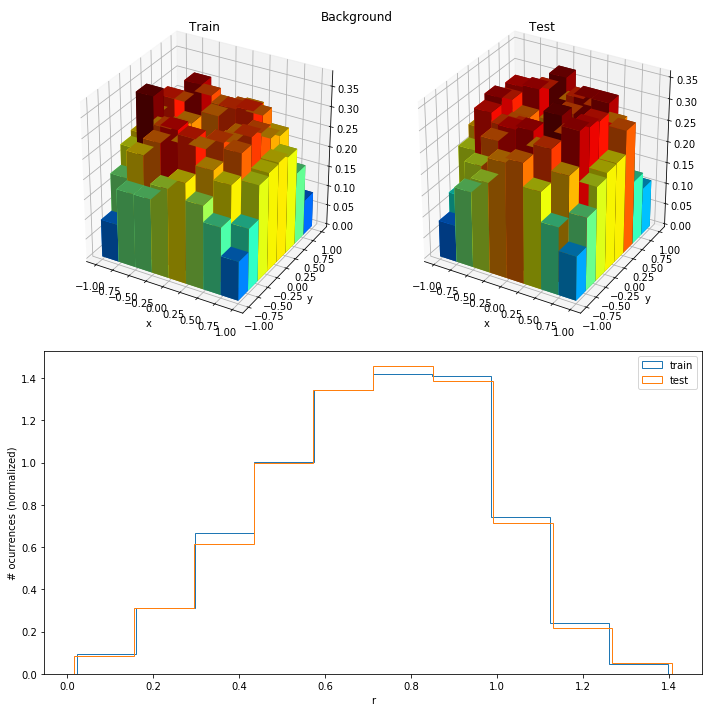

In [11]:
fig=plt.figure(figsize=(10,10))
fig.suptitle('Background')
ax1=fig.add_subplot(221,projection='3d')
hist3d(trnBX,trnBY,ax=ax1,fig=fig,bins=8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222,projection='3d')
hist3d(tstBX,tstBY,ax=ax2,fig=fig,bins=8)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnBR,normed=1,histtype='step',label='train')
ax3.hist(tstBR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

### Kolmogorov

In [8]:
#For radial distance
Skol = stat.ks_2samp(trnSR,tstSR)
Bkol = stat.ks_2samp(trnBR,tstBR)
print Skol
print Bkol

Ks_2sampResult(statistic=0.018600000000000005, pvalue=0.062138623199628297)
Ks_2sampResult(statistic=0.0093999999999999917, pvalue=0.76711145525773772)


Comment the cases for which the p-value is very low (i.e. p < 0.01).

## Part c

$$\int _{-1}^1\int _{-1}^1e^{-6 x^2+10 x y-6 y^2}dxdy=0.86787$$

In [12]:
#####################          Integration variables          #####################
x_integral = np.linspace(-1,1,2000)
Xint, Yint = np.meshgrid(x_integral,x_integral)
Fbint = fb_xy(Xint,Yint)
Fsint = fs_xy(Xint,Yint)
Aint = (x_integral[1]-x_integral[0])**2

def midpoint2d(Tcut,Tint):
    Faux = np.copy(Fsint)
    Faux[Tint < Tcut] = 0 
    alpha = np.sum(np.sum(Faux*Aint))
    Faux = np.copy(Fbint)
    Faux[Tint > Tcut] = 0 
    beta = np.sum(np.sum(Faux*Aint))
    return alpha, beta

In [13]:
# Let's try it too with the histogram of T train
Nb_r = 25
T_bins_r = np.linspace(0, np.sqrt(2),Nb_r+1)
trnShist, trnShist_edges = np.histogram(trnSR,bins=T_bins_r,normed=1)
trnBhist, trnBhist_edges = np.histogram(trnBR,bins=T_bins_r,normed=1)
hist_width_r = trnShist_edges[1]-trnShist_edges[0]

def hist_integral(Tcut):
    Tcut_i = int(Tcut/np.sqrt(2)*(Nb_r))
    if Tcut_i==Nb_r:
        alpha = sum(trnShist[Tcut_i+1:]*hist_width_r)
        beta = 1
    else:
        alpha = sum(trnShist[Tcut_i+1:]*hist_width_r)+trnShist[Tcut_i]*(hist_width_r*(Tcut_i+1)-Tcut)
        beta = sum(trnBhist[:Tcut_i]*hist_width_r)+trnBhist[Tcut_i]*(Tcut-Tcut_i*hist_width_r)
    return alpha, beta

In [14]:
N = 100
rvec = np.linspace(1e-6,np.sqrt(2),N)
alpha_r = np.empty(N)
beta_r = np.empty(N)
alpha_int_r = np.empty(N)
beta_int_r = np.empty(N)
alpha_hist_r = np.empty(N)
beta_hist_r = np.empty(N)

Tint_r = np.sqrt(Xint**2+Yint**2)

for i,Tcut in enumerate(rvec):
    alpha_r[i],beta_r[i] =rTest(Tcut)
    alpha_int_r[i], beta_int_r[i] = midpoint2d(Tcut,Tint_r)
    alpha_hist_r[i], beta_hist_r[i] = hist_integral(Tcut)

C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


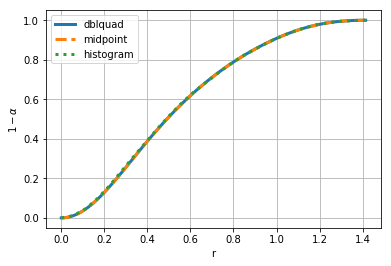

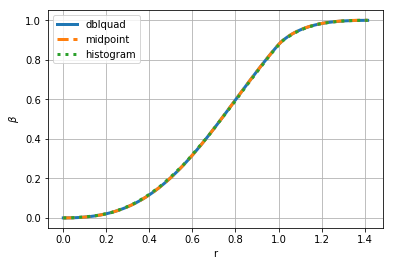

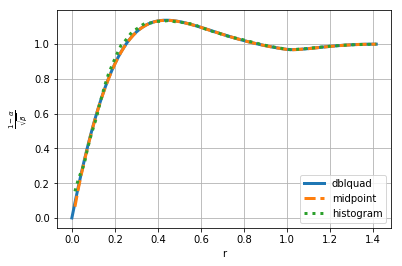

In [15]:
figs = [plt.figure(j+1) for j in range(3)]
ax1, ax2, ax3 = [fig.add_subplot(111) for fig in figs]
ax1.plot(rvec,1-alpha_r,'-',lw=3,label='dblquad')
ax1.plot(rvec,1-alpha_int_r,'--',lw=3,label='midpoint')
ax1.plot(rvec,1-alpha_hist_r,':',lw=3,label='histogram')
ax1.set_ylabel(r'$1-\alpha$')
ax2.plot(rvec,beta_r,'-',lw=3,label='dblquad')
ax2.plot(rvec,beta_int_r,'--',lw=3,label='midpoint')
ax2.plot(rvec,beta_hist_r,':',lw=3,label='histogram')
ax2.set_ylabel(r'$\beta$')
ax3.plot(rvec,(1-alpha_r)/np.sqrt(beta_r),'-',lw=3,label='dblquad')
ax3.plot(rvec,(1-alpha_int_r)/np.sqrt(beta_int_r),'--',lw=3,label='midpoint')
ax3.plot(rvec[1:],(1-alpha_hist_r[1:])/np.sqrt(beta_hist_r[1:]),':',lw=3,label='histogram')
ax3.set_ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('r')
    ax.grid(True)
    ax.legend()

### Part d

 Maximize signal-to-noise ratio

In [25]:
def maximizerTest(r):
    alpha,beta = rTest(r)
    return -(1-alpha)/np.sqrt(beta) #we write a minus so that we can find the maximum (the function minimize 
                                    # finds minima)

res = opt.minimize(maximizerTest, 1)
Tcut_opt_r = res['x']
print 'rmax=Tcut=%.3f' % Tcut_opt_r
print '1-a/sqrt(b)=%.3f' %-res['fun'] 

rmax=Tcut=0.438
1-a/sqrt(b)=1.138


### Part e

Compare the performance of the different test statistics by plotting together their signal-to-noise ratio vs. (1 − α) curves. 

Comment on the result: which test is better and why do we get the order we get.

### Part f

For each test statistic, draw the boundaries of the critical region defined by Tcut, in the (x,y) plane. Comment about the reason for the shape of the critical region in each case.

# Fischer discriminant

In [16]:
trnA, trnSfishdata, trnBfishdata, trnSCov, trnBCov = findFish(trnSX,trnSY,trnBX,trnBY)
tstA, tstSfishdata, tstBfishdata, tstSCov, tstBCov = findFish(tstSX,tstSY,tstBX,tstBY)
print trnA

[-1.38394059  0.41883978]


C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in divide


Note that $a$ is the same for both signal and background; the only difference in $a$ is between train and test.

Comment why using r and θ should be better than using x and y.

In [17]:
trnSCovXY = np.cov(np.array([trnSX,trnSY]))
trnBCovXY = np.cov(np.array([trnBX,trnBY]))
# now we compare rho, cause we have no other ideas 
print 'rhoSXY =',trnSCovXY[1,0]/np.sqrt(trnSCovXY[0,0]*trnSCovXY[1,1])
print 'rhoBXY =',trnBCovXY[1,0]/np.sqrt(trnBCovXY[0,0]*trnBCovXY[1,1])
print 'rhoSRtheta =',trnSCov[1,0]/np.sqrt(trnSCov[0,0]*trnSCov[1,1])
print 'rhoBRtheta =',trnBCov[1,0]/np.sqrt(trnBCov[0,0]*trnBCov[1,1])

rhoSXY = 0.766766629111
rhoBXY = 0.00674822012294
rhoSRtheta = 0.317541812512
rhoBRtheta = 0.00419389430949


$\rho$ is smaller for $R$ and $\theta$, which means that these two variables are not very correlated, i.e. the linear relationship between the two is very small. Therefore, if we now use these two variables in our experiment, we will add information in our test and it is likely that we get better results.

### Part b


The input of the Komogorov test is the T shown below:
 

<img src="./T_fisher.png" width="200">

In [14]:
#For the Fisher discriminant
Skol_fish = stat.ks_2samp(fisherTest(trnSfishdata,trnA),
                          fisherTest(tstSfishdata,tstA))

Bkol_fish = stat.ks_2samp(fisherTest(trnBfishdata,trnA),
                          fisherTest(tstBfishdata,tstA))

print Skol_fish
print Bkol_fish

Ks_2sampResult(statistic=0.016900000000000026, pvalue=0.11383953794374878)
Ks_2sampResult(statistic=0.012299999999999978, pvalue=0.43364421737670955)


# Summary of p-values

Comment the cases for which the p-value is very low (i.e. p < 0.01).

In [15]:
print "P-values from the Komogorov test:"

#For radial distance
print "* For Radial distance *"
print '\tSignal : %g' %Skol[1]
print '\tBackground : %g' %Bkol[1]

#For Fisher discriminant
print "* For Fisher discriminant *"
print '\tSignal : %g' %Skol_fish[1]
print '\tBackground : %g' %Bkol_fish[1]

P-values from the Komogorov test:
* For Radial distance *


NameError: name 'Skol' is not defined

Analysis of p-values: TBD

In [28]:
Tint_fish = np.empty_like(Xint)
for i,xvec in enumerate(Xint):
    Tint_fish[i,:]=fisherTest(np.array([np.sqrt(xvec**2 + Yint[i,0]**2),np.arctan(Yint[i,0]/xvec)]),trnA)  

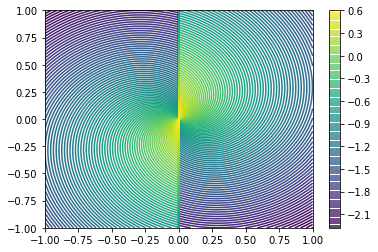

In [31]:
plt.contour(Xint,Yint,Tint_fish,100)
plt.colorbar()

In [56]:
Tcuts = np.linspace(trnA[0]*np.sqrt(2)-np.pi/4*trnA[1],
                    np.pi/2*trnA[1],100)
alpha_fish = np.empty_like(Tcuts)
beta_fish = np.empty_like(Tcuts)

for i,Tcut in enumerate(Tcuts):
    Fint = np.copy(Fsp)
    Fint[Tp < Tcut] = 0 
    alpha_fish[i] = np.sum(np.sum(Fint*d2int))
    Fint = np.copy(Fbp)
    Fint[Tp > Tcut] = 0 
    beta_fish[i] = np.sum(np.sum(Fint*d2int))

1.0
0.0207938167261
0.0206791318899


3.61999319409e-12 3.2379459626e-07


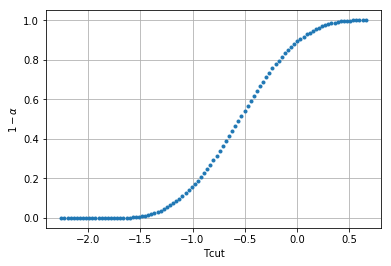

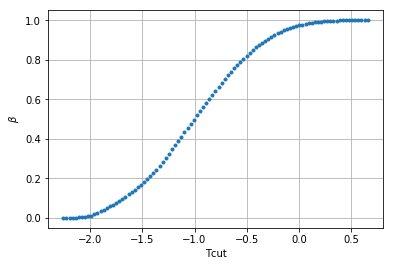

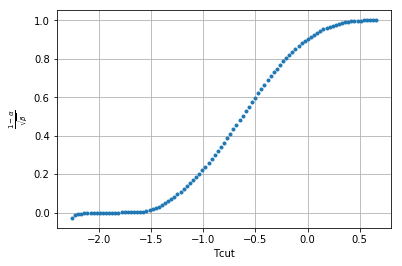

In [57]:
Tcuts=Tcuts[1:]
alpha_fish=alpha_fish[1:]
beta_fish=beta_fish[1:]
plt.figure()
plt.plot(Tcuts,1-alpha_fish,'.')
plt.xlabel('Tcut')
plt.ylabel(r'$1-\alpha$')
plt.grid(True)
plt.figure()
plt.plot(Tcuts,beta_fish,'.')
plt.xlabel('Tcut')
plt.ylabel(r'$\beta$')
plt.grid(True)
plt.figure()
plt.plot(Tcuts,(1-alpha_fish)/np.sqrt(beta_fish),'.')
plt.xlabel('Tcut')
plt.ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
plt.grid(True)
print 1-alpha[0],beta[0]